## Train current best model & create submission

In [10]:
# essentials
import os
import pathlib
from copy import copy


import pandas as pd
import numpy as np
from tqdm import tqdm

# visualisation
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn imports
import sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MaxAbsScaler, PowerTransformer, FunctionTransformer, StandardScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MaxAbsScaler, PowerTransformer, FunctionTransformer, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline, make_union, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, chi2, f_classif, SequentialFeatureSelector, RFECV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.base import clone as clone_model
from sklearn.metrics import classification_report, confusion_matrix, log_loss
from sklearn.impute import SimpleImputer, MissingIndicator, KNNImputer


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier, StackingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import RocCurveDisplay, roc_auc_score, make_scorer, roc_curve

from sklearn.preprocessing import Binarizer, Normalizer, RobustScaler, StandardScaler
from tpot.builtins import StackingEstimator, ZeroCount
from tpot.export_utils import set_param_recursive
from sklearn.preprocessing import FunctionTransformer

# others
import xgboost as xgb 
import lightgbm as lgb
import catboost as cb
import optuna

# pytorch
import torch
from torch import nn

RANDOM_SEED = 64

In [9]:
IN_KAGGLE = False

kaggle_folder = "/kaggle/input/"
local_folder = "./data/"
train_df = pd.read_csv(kaggle_folder if IN_KAGGLE else local_folder + "playground-series-s3e26/train.csv", index_col="id")
test_df = pd.read_csv(kaggle_folder if IN_KAGGLE else local_folder  + "playground-series-s3e26/test.csv", index_col="id")
original_df = pd.read_csv(kaggle_folder if IN_KAGGLE else local_folder  + "cirrhosis-prediction-dataset/cirrhosis.csv", index_col="ID")

original_df['generated'] = 0
train_df['generated'] = 1
test_df['generated'] = 1
train_df = pd.concat([train_df, original_df], axis=0)
train_df = train_df.reset_index(drop=True)

target_column = "Status"

target_map = {"C": "censored", "CL": "censored due to liver transplant", "D": "death"} # for readability of charts
train_df[target_column] = train_df[target_column].map(target_map)

categorical_features = ["Drug", "Sex", "Ascites", "Hepatomegaly", "Spiders", "Edema", "Stage"]
numerical_features = ["N_Days", "Age", "Bilirubin", "Cholesterol", "Albumin", "Copper", "Alk_Phos", "SGOT", "Tryglicerides", "Platelets", "Prothrombin"]

def num_features_2(df):
    normal_ranges = {
        'Bilirubin': (0.1, 1.2),
        'Cholesterol': (0, 200),
        'Albumin': (3.5, 5.5),
        'Copper': (10, 30),
        'Alk_Phos': (40, 129),
        'SGOT': (8, 45),
        'Tryglicerides': (48.68, 168.15),
        'Platelets': (150, 400),
        'Prothrombin': (9.4, 12.5)
    }

    for feature, (normal_range_min, normal_range_max) in normal_ranges.items():
        if feature == 'Albumin':
            df[f'{feature}_is_normal'] = (df[feature] >= normal_range_min)
        else:
            df[f'{feature}_is_normal'] = (df[feature] >= normal_range_min) & (df[feature] <= normal_range_max) 

        # Add deviation calculation as before
        df.loc[~df[f'{feature}_is_normal'], f'{feature}_deviation'] = df[feature] - ((normal_range_min + normal_range_max) / 2)

    threshold_platelets = 150
    df['thrombocytopenia'] = np.where(df['Platelets'] < threshold_platelets, 1, 0)


    df.fillna(0, inplace=True)
    
    new_cat_feature_names = [f'{feature}_is_normal' for feature in normal_ranges.keys() ]
    new_num_feature_names = [f'{feature}_deviation' for feature in normal_ranges.keys()]

    new_cat_feature_names.append('thrombocytopenia')
    
    return df, new_cat_feature_names, new_num_feature_names

def num_features_3(df):
    ##initial pass as creating features for meaningful cutoffs
    df['APRI']=100 * (df['SGOT'])/df['Platelets']
    df['under769days']=np.where(df['N_Days']<769, 1, 0)
    df['bilirubin_1.2']=np.where(df['Bilirubin']>1.2, 1, 0)
    df['albumin_low']=np.where(df['Albumin']<2.23, 1, 0)
    df['copper_high']=np.where(df['Copper']>73, 1, 0)
    df['SGOT_high']=np.where(df['SGOT']>73, 1, 0)
    df['Prothrombin_high']=np.where(df['Prothrombin']>10.8, 1, 0)
    df['Edema_yn']=np.where(df['Edema']=='N', 0, 1)
    df['bilirubin_3']=np.where(df['Bilirubin']>3, 1, 0)
    df['high_cholesteroal']=np.where(df['Cholesterol']>240, 1, 0)
    df['age_over_70']=np.where((df['Age']/365)>=70, 1, 0)
    df['abnormal_alp']=np.where(((df['Alk_Phos']<30 )| (df['Alk_Phos']>147)), 1, 0)
    df['very_high_tri']=np.where(df['Tryglicerides']>500, 1, 0)
    df['high_tri']=np.where(df['Tryglicerides']>200, 1, 0)
    df['copper_deficient']=np.where(((df['Sex']=='F') & (df['Copper']<80) |(df['Sex']=='M') & (df['Copper']<70)), 1, 0)
    df['FIB4']=(df['Age']/365)* (df['SGOT']/df['Platelets'])
    df['ALBI']=.66*np.log(df['Bilirubin'])-.085 * df['Albumin']

    new_cat_feature_names = [
        "under769days",
        "bilirubin_1.2",
        "albumin_low",
        "copper_high",
        "SGOT_high",
        "Prothrombin_high",
        "Edema_yn",
        "bilirubin_3",
        "high_cholesteroal",
        "age_over_70",
        "abnormal_alp",
        "very_high_tri",
        "high_tri",
        "copper_deficient",
    ]
    new_num_feature_names = [
        "APRI",
        "FIB4",
        "ALBI",
    ]

    
    return df, new_cat_feature_names, new_num_feature_names

def base_feature_engineering(df):
    df['Drug'] = df['Drug'].map({"D-penicillamine": 1,"Placebo": 0})
    df['Sex'] = df['Sex'].map({"F": 1,"M": 0})
    
    df["Stage"] = df["Stage"].apply(lambda x: str(x))
    df['Stage'] = df['Stage'].astype('category')

    for c in categorical_features:
        df[c] = df[c].astype('category')
    return df


train_df, new_cat, new_num = num_features_2(train_df)
train_df = base_feature_engineering(train_df)


categorical_features += new_cat
numerical_features += new_num

X = train_df.drop(columns=target_column)
y = train_df[target_column]

le = LabelEncoder()
y = le.fit_transform(y)


num_imputer = KNNImputer(n_neighbors=10)
cat_imputer = SimpleImputer(strategy="constant", fill_value="missing", add_indicator=True)

numeric_transformer = Pipeline(
    [
        ("num_imputer", num_imputer),
        #("power_transformer", PowerTransformer()),
        ("robust_scaler", RobustScaler()),
    ]
)

categorical_transformer = Pipeline(
    [
        ("cast as str", FunctionTransformer(lambda x: x.astype(str), validate=False)),
        ("cat_imputer", cat_imputer),
        ("onehot", OneHotEncoder(handle_unknown="ignore", drop="if_binary")),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)
# preprocess data
X = preprocessor.fit_transform(X)

X

array([[-0.56637168,  0.55166341,  0.52173913, ...,  1.        ,
         1.        ,  0.        ],
       [ 0.50578625,  0.10254403, -0.08695652, ...,  1.        ,
         1.        ,  0.        ],
       [ 1.0871341 , -0.97573386,  0.95652174, ...,  1.        ,
         1.        ,  0.        ],
       ...,
       [-0.52825051,  0.41213307,  0.2173913 , ...,  0.        ,
         1.        ,  1.        ],
       [-0.77603812,  0.48375734, -0.13043478, ...,  1.        ,
         1.        ,  0.        ],
       [-0.58202859,  0.12622309, -0.17391304, ...,  1.        ,
         1.        ,  0.        ]])

## Network model

In [50]:
def evaluate(val_loader, model, device):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    total_loss = 0.0
    for k, (data, labels) in enumerate(val_loader):
        outputs = model(data.to(device))
        loss = criterion(outputs, labels.to(device))
        total_loss += loss.item()
    return total_loss / len(val_loader)

def train(train_loader, val_loader, model, device, num_epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # move model to the right device
    model.to(device)
    model.train()

    train_losses = []
    val_losses = []
    print('Training started...')
    # Train the data multiple times
    for epoch in range(num_epochs):
        
        # Save Train and Test Loss
        train_loss = 0
        
        # Set model in training mode:
        model.train()
        
        for k, (data, labels) in enumerate(train_loader):
            
            # Create log probabilities
            out = model(data.to(device))
            # Clears the gradients from previous iteration
            optimizer.zero_grad()
            # Computes loss: how far is the prediction from the actual?
            loss = criterion(out, labels.to(device))
            # Computes gradients for neurons
            loss.backward()
            # Updates the weights
            optimizer.step()
            
            # Save Loss & Accuracy after each iteration
            train_loss += loss.item()
        
        train_losses.append(train_loss/k)
        if val_loader:
            val_losses.append(evaluate(val_loader, model, device))

        # Print Average Train Loss & Accuracy after each epoch
        print('TRAIN | Epoch: {}/{} | Loss: {:.2f}'.format(epoch+1, num_epochs, train_loss/k))

    return model, train_losses, val_losses

Training started...
TRAIN | Epoch: 1/20 | Loss: 0.90
TRAIN | Epoch: 2/20 | Loss: 0.63
TRAIN | Epoch: 3/20 | Loss: 0.59
TRAIN | Epoch: 4/20 | Loss: 0.57
TRAIN | Epoch: 5/20 | Loss: 0.57
TRAIN | Epoch: 6/20 | Loss: 0.55
TRAIN | Epoch: 7/20 | Loss: 0.54
TRAIN | Epoch: 8/20 | Loss: 0.54
TRAIN | Epoch: 9/20 | Loss: 0.54
TRAIN | Epoch: 10/20 | Loss: 0.53
TRAIN | Epoch: 11/20 | Loss: 0.52
TRAIN | Epoch: 12/20 | Loss: 0.51
TRAIN | Epoch: 13/20 | Loss: 0.51
TRAIN | Epoch: 14/20 | Loss: 0.51
TRAIN | Epoch: 15/20 | Loss: 0.50
TRAIN | Epoch: 16/20 | Loss: 0.49
TRAIN | Epoch: 17/20 | Loss: 0.48
TRAIN | Epoch: 18/20 | Loss: 0.48
TRAIN | Epoch: 19/20 | Loss: 0.48
TRAIN | Epoch: 20/20 | Loss: 0.46
[0.9006383275985718, 0.6261842799186706, 0.5903001379966736, 0.5719364583492279, 0.5704503738880158, 0.5517006051540375, 0.541795893907547, 0.536575174331665, 0.5374414145946502, 0.5252661120891571, 0.5159217715263367, 0.5098756611347198, 0.5088999569416046, 0.5054337334632873, 0.50319509267807, 0.4909312319

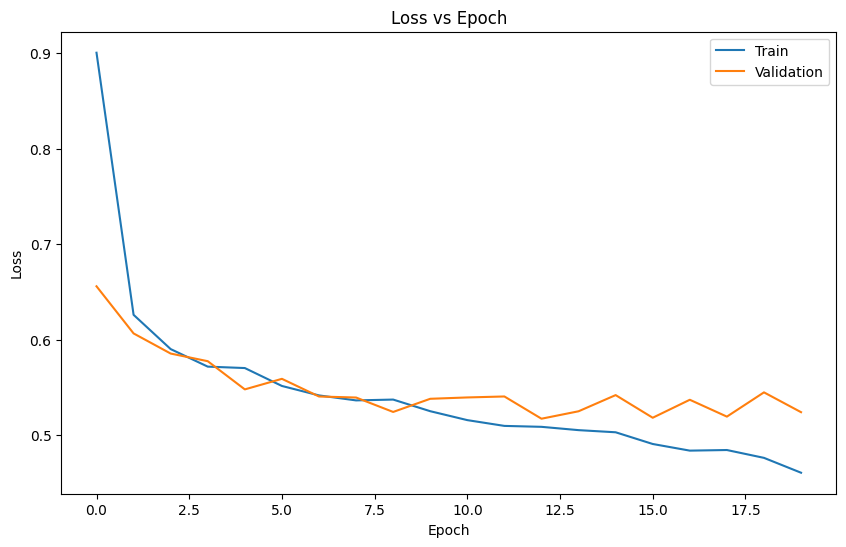

In [62]:
device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 256
num_epochs = 20

class NeuralNetwork(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
# create train test split
    
def create_dataloader(X, y, batch_size=32):
    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.long)
    dataset = torch.utils.data.TensorDataset(X, y)
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
                                       
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=train_df[target_column], random_state=RANDOM_SEED)

train_loader = create_dataloader(X_train, y_train, batch_size=batch_size)
test_loader = create_dataloader(X_test, y_test, batch_size=batch_size)

# create model
input_size = np.prod(X_train.shape[1:])
model = NeuralNetwork(input_size=input_size, num_classes=3)

model, train_losses, val_losses = train(train_loader, test_loader, model, device=device, num_epochs=num_epochs)

print(train_losses)
# plot losses vs epochs

def plot_losses(train_losses, val_losses=None, num_epochs=10):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(range(num_epochs), train_losses,  label="Train")
    if val_losses:
        ax.plot(range(num_epochs), val_losses, label="Validation")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.set_title("Loss vs Epoch")
    ax.legend()
    plt.show()

plot_losses(train_losses, val_losses, num_epochs=num_epochs)

## Submission

/home/wiktor/.pyenv/versions/3.10.11/envs/kaggling/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Training started...
TRAIN | Epoch: 1/13 | Loss: 0.62
TRAIN | Epoch: 2/13 | Loss: 0.53
TRAIN | Epoch: 3/13 | Loss: 0.51
TRAIN | Epoch: 4/13 | Loss: 0.49
TRAIN | Epoch: 5/13 | Loss: 0.47
TRAIN | Epoch: 6/13 | Loss: 0.47
TRAIN | Epoch: 7/13 | Loss: 0.45
TRAIN | Epoch: 8/13 | Loss: 0.44
TRAIN | Epoch: 9/13 | Loss: 0.43
TRAIN | Epoch: 10/13 | Loss: 0.41
TRAIN | Epoch: 11/13 | Loss: 0.40
TRAIN | Epoch: 12/13 | Loss: 0.38
TRAIN | Epoch: 13/13 | Loss: 0.37


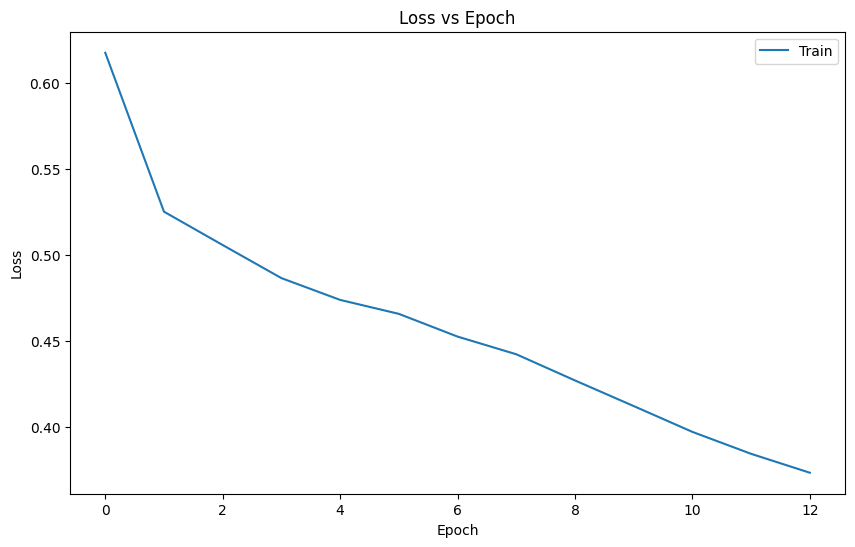

In [63]:
IN_KAGGLE = False

num_epochs = 13

kaggle_folder = "/kaggle/input/"
local_folder = "./data/"
train_df = pd.read_csv(kaggle_folder if IN_KAGGLE else local_folder + "playground-series-s3e26/train.csv", index_col="id")
test_df = pd.read_csv(kaggle_folder if IN_KAGGLE else local_folder  + "playground-series-s3e26/test.csv", index_col="id")
original_df = pd.read_csv(kaggle_folder if IN_KAGGLE else local_folder  + "cirrhosis-prediction-dataset/cirrhosis.csv", index_col="ID")

categorical_features = ["Drug", "Sex", "Ascites", "Hepatomegaly", "Spiders", "Edema", "Stage"]
numerical_features = ["N_Days", "Age", "Bilirubin", "Cholesterol", "Albumin", "Copper", "Alk_Phos", "SGOT", "Tryglicerides", "Platelets", "Prothrombin"]

#categorical_features += ["generated"]
#original_df['generated'] = 0
#train_df['generated'] = 1
#test_df['generated'] = 1
train_df = pd.concat([train_df, original_df], axis=0)
train_df = train_df.reset_index(drop=True)

target_column = "Status"

train_df, new_cat, new_num = num_features_2(train_df)
train_df = base_feature_engineering(train_df)

categorical_features += new_cat
numerical_features += new_num

test_df, _, _ = num_features_2(test_df)
test_df = base_feature_engineering(test_df)

le = LabelEncoder()

X_train = train_df.drop(columns=target_column)
y_train = le.fit_transform(train_df[target_column])

X_test = test_df


num_imputer = SimpleImputer(strategy="constant", add_indicator=True)
cat_imputer = SimpleImputer(strategy="constant", fill_value="MISSING", add_indicator=True)

numeric_transformer = Pipeline(
    [
        ("num_imputer", num_imputer),
        ("standard scaler", StandardScaler()),
        #("power_transformer", PowerTransformer()),
    ]
)

categorical_transformer = Pipeline(
    [
        ("cast as str", FunctionTransformer(lambda x: x.astype(str), validate=False)),
        ("cat_imputer", cat_imputer),
        ("onehot", OneHotEncoder(handle_unknown="ignore", drop="if_binary")),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# preprocess data
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

train_dl = create_dataloader(X_train, y_train, batch_size=batch_size)

model = NeuralNetwork(input_size=input_size, num_classes=3)

model, train_losses, _ = train(train_dl, None, model, device=device, num_epochs=num_epochs)

plot_losses(train_losses, None, num_epochs=num_epochs)

In [66]:
# make predictions

def predict(model, X, device):
    model.eval()
    X = torch.tensor(X, dtype=torch.float32)
    with torch.no_grad():
        logits = model(X.to(device))
        probs = nn.functional.softmax(logits, dim=-1)
    return probs.cpu().numpy()

probs = predict(model, X_test, device)

probs_df = pd.DataFrame(probs, index=test_df.index, columns=[f"Status_{target}" for target in le.classes_])
probs_df

,Status_C,Status_CL,Status_D
id,,,
7905,0.470358,0.001934,0.527707
7906,0.876985,0.026836,0.096179
7907,0.000033,0.000365,0.999602
7908,0.984604,0.000669,0.014727
7909,0.526010,0.023494,0.450496
...,...,...,...
13171,0.949102,0.037579,0.013319
13172,0.993553,0.000406,0.006041
13173,0.963136,0.000565,0.036299
